In [ ]:
#!pip install pmdarima
# !pip install bootcamp_utils

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt
# import pmdarima as pm
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
from bokeh.io import show, output_file
# import bootcamp_utils


from sklearn.preprocessing import LabelEncoder, StandardScaler

## Data

Cases & Deaths by County

In [ ]:
!wget -q -O covid_county.csv https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
covid_county = pd.read_csv('covid_county.csv', parse_dates=['date'], index_col=['date'])
covid_county

,county,state,fips,cases,deaths
date,,,,,
2020-01-21,Snohomish,Washington,53061.0,1,0
2020-01-22,Snohomish,Washington,53061.0,1,0
2020-01-23,Snohomish,Washington,53061.0,1,0
2020-01-24,Cook,Illinois,17031.0,1,0
2020-01-24,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...
2020-08-06,Sweetwater,Wyoming,56037.0,253,2
2020-08-06,Teton,Wyoming,56039.0,367,1
2020-08-06,Uinta,Wyoming,56041.0,272,1


In [ ]:
fips_county_state = covid_county[['county', 'state', 'fips']]
fips_county_state = fips_county_state.drop_duplicates()
fips_county_state

,county,state,fips
date,,,
2020-01-21,Snohomish,Washington,53061.0
2020-01-24,Cook,Illinois,17031.0
2020-01-25,Orange,California,6059.0
2020-01-26,Maricopa,Arizona,4013.0
2020-01-26,Los Angeles,California,6037.0
...,...,...,...
2020-08-04,Prairie,Montana,30079.0
2020-08-05,Phillips,Montana,30071.0
2020-08-06,Arthur,Nebraska,31005.0


Deaths by State, Age, & Sex

In [ ]:
!wget -q -O age_sex.csv https://www.dropbox.com/s/iahww1pvnkqftet/Provisional_COVID-19_Death_Counts_by_Sex__Age__and_State.csv?dl=0
age_sex = pd.read_csv('age_sex.csv')

In [ ]:
age_sex

,Data as of,Start week,End Week,State,Sex,Age group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths"
0,7/22/2020,2/1/2020,7/11/2020,United States,All,Under 1 year,11.0,8072.0,75.0,2.0,14.0,98.0
1,7/22/2020,2/1/2020,7/11/2020,United States,All,1-4 years,9.0,1547.0,52.0,2.0,41.0,100.0
2,7/22/2020,2/1/2020,7/11/2020,United States,All,5-14 years,16.0,2379.0,78.0,5.0,49.0,138.0
3,7/22/2020,2/1/2020,7/11/2020,United States,All,15-24 years,190.0,14810.0,300.0,62.0,51.0,475.0
4,7/22/2020,2/1/2020,7/11/2020,United States,All,25-34 years,935.0,30885.0,1113.0,416.0,149.0,1768.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1411,7/22/2020,2/1/2020,7/11/2020,Puerto Rico,Female,75-84 years,0.0,0.0,0.0,0.0,0.0,0.0
1412,7/22/2020,2/1/2020,7/11/2020,Puerto Rico,Female,85 years and over,0.0,0.0,0.0,0.0,0.0,0.0
1413,7/22/2020,2/1/2020,7/11/2020,Puerto Rico,Female,All ages,NaN,434.0,44.0,NaN,NaN,52.0
1414,7/22/2020,2/1/2020,7/11/2020,Puerto Rico,Unknown,All ages,0.0,NaN,0.0,0.0,0.0,0.0


In [ ]:
dropped_cols_age_sex = age_sex[['State','Sex','Age group','COVID-19 Deaths']].copy()
total_age_sex = dropped_cols_age_sex[dropped_cols_age_sex.State.str.contains('Total')]
total_age_sex.drop(columns=['Sex','Age group'], inplace=True)
total_age_sex['State'] = total_age_sex['State'].str.replace(r' Total','')
total_age_sex_by_state = total_age_sex.groupby('State')
total_age_sex_by_state.first()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,COVID-19 Deaths
State,
Alabama,1265.0
Alaska,11.0
Arizona,2443.0
Arkansas,362.0
California,7100.0
Colorado,1643.0
Connecticut,4031.0
Delaware,517.0
District of Columbia,644.0


In [ ]:
percent_age_sex = dropped_cols_age_sex[~dropped_cols_age_sex.State.str.contains('Total')]
percent_age_sex = percent_age_sex[~percent_age_sex.State.str.contains('United States')]
percent_age_sex['percent death']=percent_age_sex.apply(lambda x:x['COVID-19 Deaths']/total_age_sex_by_state.get_group(x['State']).values[0][0],axis=1)#x['COVID-19 Deaths']/total_age_sex_by_state.get_group(x['State']).values[0][0] )
percent_age_sex.fillna(0,inplace=True)
percent_age_sex

,State,Sex,Age group,COVID-19 Deaths,percent death
38,Alabama,Male,Under 1 year,0.0,0.0
39,Alabama,Male,1-4 years,0.0,0.0
40,Alabama,Male,5-14 years,0.0,0.0
41,Alabama,Male,15-24 years,0.0,0.0
42,Alabama,Male,25-34 years,0.0,0.0
...,...,...,...,...,...
1410,Puerto Rico,Female,65-74 years,0.0,0.0
1411,Puerto Rico,Female,75-84 years,0.0,0.0
1412,Puerto Rico,Female,85 years and over,0.0,0.0
1413,Puerto Rico,Female,All ages,0.0,0.0


Population by county


In [ ]:
!wget -q -O population_county.csv https://www.dropbox.com/s/7au0ve0nlppjbx1/co-est2019-alldata.csv?dl=0
population_county = pd.read_csv('population_county.csv', encoding='latin-1')

In [ ]:
population_county

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,NPOPCHG_2019,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,BIRTHS2019,DEATHS2010,...,RDEATH2016,RDEATH2017,RDEATH2018,RDEATH2019,RNATURALINC2011,RNATURALINC2012,RNATURALINC2013,RNATURALINC2014,RNATURALINC2015,RNATURALINC2016,RNATURALINC2017,RNATURALINC2018,RNATURALINC2019,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RINTERNATIONALMIG2019,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,4799069,4815588,4830081,4841799,4852347,4863525,4874486,4887681,4903185,5312,13632,16519,14493,11718,10548,11178,10961,13195,15504,14226,59690,59067,57929,58903,59647,59389,58961,58271,57313,11075,...,10.644438,10.925229,10.994485,11.005972,2.265531,2.225976,1.467602,1.900561,1.603236,1.580712,1.184225,0.943643,0.701470,0.973446,1.210028,1.046273,0.761796,0.944900,1.189188,0.618401,0.692264,0.566242,-0.395013,-0.023714,0.476276,-0.198307,-0.318543,-0.444016,0.471965,1.081522,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,55227,54954,54727,54893,54864,55243,55390,55533,55869,176,454,-273,-227,166,-29,379,147,143,336,150,638,615,571,640,651,666,676,631,624,157,...,9.935790,10.358573,9.339812,9.712572,2.254545,0.998357,-0.200582,1.222405,1.220879,2.161534,1.862012,2.037449,1.490099,0.072727,-0.254127,0.218816,0.127714,0.236887,-0.054492,-0.216933,-0.126214,-0.287248,5.945455,-5.971992,-4.121042,1.842729,-1.949762,4.831664,1.066590,0.667129,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,186558,190145,194885,199183,202939,207601,212521,217855,223234,847,3446,3587,4740,4298,3756,4662,4920,5334,5379,516,2189,2093,2160,2212,2257,2300,2300,2310,2304,533,...,9.850441,9.992336,10.744094,10.546624,1.947683,1.104318,1.350544,1.141935,0.790805,1.354314,0.956865,-0.009294,-0.099753,0.957611,1.268904,1.059658,0.573505,0.651544,0.876894,0.409405,0.450769,0.362739,15.684259,16.219674,21.691816,19.610829,17.074420,20.402397,21.988851,24.276447,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,27341,27169,26937,26755,26283,25806,25157,24872,24686,-128,14,-172,-232,-182,-472,-477,-649,-285,-186,71,331,300,282,264,271,276,280,263,256,131,...,10.750830,11.577026,13.152372,12.591307,0.292676,0.513667,-0.480538,-1.638978,-2.300238,-0.153583,-0.588662,-2.638470,-2.259978,-0.182922,-0.440286,-0.369645,0.148998,0.490215,0.652729,0.470930,0.479722,0.524638,0.475598,-6.457531,-7.762540,-5.289429,-16.214789,-18.890745,-25.469458,-9.234644,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,22745,22667,22521,22553,22566,22586,22550,22367,22394,-45,-125,-78,-146,32,13,20,-36,-183,27,44,264,246,258,253,251,276,291,232,240,32,...,10.675053,11.166253,11.710488,11.259802,-0.526143,0.440412,-0.752412,0.266229,-0.620581,1.550319,1.728111,-1.380324,-0.536181,0.438452,0.836783,0.885191,0.621201,0.576254,0.620128,0.443105,0.445266,0.446818,-5.436808,-4.624328,-6.683190,0.709944,0.753563,-1.32884

In [ ]:
population_county["FIPS code"] = population_county["STATE"].astype(str).str.zfill(2) + \
                                 population_county["COUNTY"].astype(str).str.zfill(3)
population_county_clean = population_county[["FIPS code", "STNAME", "CTYNAME", "POPESTIMATE2019"]]
population_county_clean = population_county_clean[population_county_clean["STNAME"] != population_county_clean["CTYNAME"]]
population_county_clean

,FIPS code,STNAME,CTYNAME,POPESTIMATE2019
1,01001,Alabama,Autauga County,55869
2,01003,Alabama,Baldwin County,223234
3,01005,Alabama,Barbour County,24686
4,01007,Alabama,Bibb County,22394
5,01009,Alabama,Blount County,57826
...,...,...,...,...
3188,56037,Wyoming,Sweetwater County,42343
3189,56039,Wyoming,Teton County,23464
3190,56041,Wyoming,Uinta County,20226
3191,56043,Wyoming,Washakie County,7805


Underlying conditions

In [ ]:
!wget -q -O underlying_conditions.csv https://www.dropbox.com/s/3vfi3bgpdelcjbc/conditions_data.csv?dl=0
underlying_conditions = pd.read_csv('underlying_conditions.csv')

In [ ]:
underlying_conditions

,Unnamed: 0,Total,Male,Female,≤9,10–19,20–29,30–39,40–49,50–59,60–69,70–79,≥80
0,Total population,1320488,646358,674130,20458,49245,182469,214849,219139,235774,179007,105252,114295
1,Known underlying medical condition status*,"287,320","138,887","148,433","2,896","7,123","27,436","33,483","40,572","54,717","50,125","34,400","36,568"
2,Any cardiovascular disease¶,"92,546","47,567","44,979",78,164,"1,177","3,588","8,198","16,954","21,466","18,763","22,158"
3,Any chronic lung disease,"50,148","20,930","29,218",363,"1,285","4,537","5,110","6,127","8,722","9,200","7,436","7,368"
4,Renal disease,"21,908","12,144","9,764",21,34,204,587,"1,273","2,789","4,764","5,401","6,835"
5,Diabetes,"86,737","45,089","41,648",12,225,"1,409","4,106","9,636","19,589","22,314","16,594","12,852"
6,Liver disease,"3,953","2,439","1,514",5,19,132,390,573,878,"1,074",583,299
7,Immunocompromised,"15,265","7,345","7,920",61,146,646,"1,253","2,005","3,190","3,421","2,486","2,057"
8,Neurologic/Neurodevelopmental disability,"13,665","6,193","7,472",41,113,395,533,734,"1,338","2,006","2,759","5,746"


In [ ]:
table = underlying_conditions.set_index(underlying_conditions["Unnamed: 0"]).drop(columns="Unnamed: 0").T
table = table.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
table.replace(',','', regex=True, inplace=True)
table = table.astype(float)
underlying_conditions_table = table.div(table["Total population"], axis=0)
underlying_conditions_table

Unnamed: 0,Total population,Known underlying medical condition status*,Any cardiovascular disease¶,Any chronic lung disease,Renal disease,Diabetes,Liver disease,Immunocompromised,Neurologic/Neurodevelopmental disability
Total,1.0,0.217586,0.070085,0.037977,0.016591,0.065686,0.002994,0.011560,0.010348
Male,1.0,0.214876,0.073592,0.032381,0.018788,0.069759,0.003773,0.011364,0.009581
Female,1.0,0.220185,0.066722,0.043342,0.014484,0.061780,0.002246,0.011748,0.011084
≤9,1.0,0.141558,0.003813,0.017744,0.001026,0.000587,0.000244,0.002982,0.002004
10–19,1.0,0.144644,0.003330,0.026094,0.000690,0.004569,0.000386,0.002965,0.002295
20–29,1.0,0.150360,0.006450,0.024864,0.001118,0.007722,0.000723,0.003540,0.002165
30–39,1.0,0.155844,0.016700,0.023784,0.002732,0.019111,0.001815,0.005832,0.002481
40–49,1.0,0.185143,0.037410,0.027959,0.005809,0.043972,0.002615,0.009149,0.003349
50–59,1.0,0.232074,0.071908,0.036993,0.011829,0.083084,0.003724,0.013530,0.005675
60–69,1.0,0.280017,0.119917,0.051395,0.026613,0.124654,0.006000,0.019111,0.011206


Symptoms

In [ ]:
!wget -q -O symptoms.csv https://www.dropbox.com/s/tvybob24ym826w2/symptoms_data.csv?dl=0
symptoms = pd.read_csv('symptoms.csv')

In [ ]:
table = symptoms.set_index(symptoms["Unnamed: 0"]).drop(columns="Unnamed: 0").T
table = table.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
table.replace(',','', regex=True, inplace=True)
table = table.astype(float)
symptoms_table = table.div(table["Total population"], axis=0)
symptoms_table

Unnamed: 0,Total population,"Fever, cough, or shortness of breath",Fever††,Cough,Shortness of breath,Myalgia,Runny nose,Sore throat,Headache,Nausea/Vomiting,Abdominal pain,Diarrhea,Loss of smell or taste
Total,1.0,0.197432,0.121978,0.142336,0.080566,0.102255,0.017198,0.056676,0.097358,0.032422,0.021540,0.054555,0.023621
Male,1.0,0.194579,0.124665,0.137970,0.077100,0.095801,0.015317,0.048339,0.084661,0.025603,0.017874,0.049652,0.019675
Female,1.0,0.200166,0.119403,0.146522,0.083890,0.108442,0.019002,0.064670,0.109532,0.038960,0.025055,0.059256,0.027404
≤9,1.0,0.160231,0.117509,0.093460,0.016571,0.026249,0.017304,0.032457,0.038371,0.024734,0.017059,0.034412,0.003275
10–19,1.0,0.154005,0.090222,0.106752,0.042035,0.075886,0.020814,0.073672,0.107930,0.026683,0.019860,0.034765,0.025525
20–29,1.0,0.192208,0.111696,0.144046,0.074802,0.115927,0.025160,0.079427,0.130011,0.036434,0.023078,0.054075,0.037420
30–39,1.0,0.195561,0.120489,0.145744,0.078432,0.123175,0.020507,0.069142,0.121676,0.035658,0.023970,0.059432,0.032148
40–49,1.0,0.206996,0.129630,0.155294,0.086603,0.128065,0.018897,0.066122,0.119764,0.036922,0.025240,0.063695,0.029027
50–59,1.0,0.217509,0.137314,0.162465,0.090455,0.121277,0.017390,0.059082,0.110517,0.037057,0.026016,0.065894,0.024719
60–69,1.0,0.210612,0.131788,0.151670,0.089483,0.096979,0.014921,0.045764,0.082315,0.033256,0.021278,0.057813,0.016368


Combining symptoms and underlying conditions

In [ ]:
conditions_symptoms = symptoms_table
conditions_symptoms[["Known underlying medical condition status","Any cardiovascular disease", "Any chronic lung disease","Renal disease","Diabetes","Liver disease","Immunocompromised","Neurologic/Neurodevelopmental disability"]] = underlying_conditions_table[["Known underlying medical condition status*","Any cardiovascular disease¶","Any chronic lung disease","Renal disease","Diabetes","Liver disease","Immunocompromised","Neurologic/Neurodevelopmental disability"]]
conditions_symptoms

Unnamed: 0,Total population,"Fever, cough, or shortness of breath",Fever††,Cough,Shortness of breath,Myalgia,Runny nose,Sore throat,Headache,Nausea/Vomiting,Abdominal pain,Diarrhea,Loss of smell or taste,Known underlying medical condition status,Any cardiovascular disease,Any chronic lung disease,Renal disease,Diabetes,Liver disease,Immunocompromised,Neurologic/Neurodevelopmental disability
Total,1.0,0.197432,0.121978,0.142336,0.080566,0.102255,0.017198,0.056676,0.097358,0.032422,0.021540,0.054555,0.023621,0.217586,0.070085,0.037977,0.016591,0.065686,0.002994,0.011560,0.010348
Male,1.0,0.194579,0.124665,0.137970,0.077100,0.095801,0.015317,0.048339,0.084661,0.025603,0.017874,0.049652,0.019675,0.214876,0.073592,0.032381,0.018788,0.069759,0.003773,0.011364,0.009581
Female,1.0,0.200166,0.119403,0.146522,0.083890,0.108442,0.019002,0.064670,0.109532,0.038960,0.025055,0.059256,0.027404,0.220185,0.066722,0.043342,0.014484,0.061780,0.002246,0.011748,0.011084
≤9,1.0,0.160231,0.117509,0.093460,0.016571,0.026249,0.017304,0.032457,0.038371,0.024734,0.017059,0.034412,0.003275,0.141558,0.003813,0.017744,0.001026,0.000587,0.000244,0.002982,0.002004
10–19,1.0,0.154005,0.090222,0.106752,0.042035,0.075886,0.020814,0.073672,0.107930,0.026683,0.019860,0.034765,0.025525,0.144644,0.003330,0.026094,0.000690,0.004569,0.000386,0.002965,0.002295
20–29,1.0,0.192208,0.111696,0.144046,0.074802,0.115927,0.025160,0.079427,0.130011,0.036434,0.023078,0.054075,0.037420,0.150360,0.006450,0.024864,0.001118,0.007722,0.000723,0.003540,0.002165
30–39,1.0,0.195561,0.120489,0.145744,0.078432,0.123175,0.020507,0.069142,0.121676,0.035658,0.023970,0.059432,0.032148,0.155844,0.016700,0.023784,0.002732,0.019111,0.001815,0.005832,0.002481
40–49,1.0,0.206996,0.129630,0.155294,0.086603,0.128065,0.018897,0.066122,0.119764,0.036922,0.025240,0.063695,0.029027,0.185143,0.037410,0.027959,0.005809,0.043972,0.002615,0.009149,0.003349
50–59,1.0,0.217509,0.137314,0.162465,0.090455,0.121277,0.017390,0.059082,0.110517,0.037057,0.026016,0.065894,0.024719,0.232074,0.071908,0.036993,0.011829,0.083084,0.003724,0.013530,0.005675
60–69,1.0,0.210612,0.131788,0.151670,0.089483,0.096979,0.014921,0.045764,0.082315,0.033256,0.021278,0.057813,0.016368,0.280017,0.119917,0.051395,0.026613,0.124654,0.006000,0.019111,0.011206


Underlying Conditions Again

In [ ]:
!wget -q -O underlying.csv https://www.dropbox.com/s/kgofwj59ecxh4cg/covid_things.csv?dl=0
underlying_data = pd.read_csv('underlying.csv', encoding='latin-1')

In [ ]:
underlying_data

,Group,Thing,ALL_THING,ALL,ALL_%,COND_THING,COND_ALL,COND_%,NONE_THING,NONE_ALL,NONE_%
0,Male,Hospital,"101,133","646,358",15.6,"49,503","96,839",51.1,"3,596","42,048",8.6
1,Female,Hospital,"83,540","674,130",12.4,"40,698","102,040",39.9,"3,087","46,393",6.7
2,<=9,Hospital,848,"20,458",4.1,138,619,22.3,84,"2,277",3.7
3,10-19,Hospital,"1,234","49,245",2.5,309,"2,076",14.9,115,"5,047",2.3
4,20-29,Hospital,"6,704","182,469",3.7,"1,559","8,906",17.5,498,"18,530",2.7
5,30-39,Hospital,"12,570","214,849",5.9,"3,596","14,854",24.2,828,"18,629",4.4
6,40-49,Hospital,"19,318","219,139",8.8,"7,151","24,161",29.6,"1,057","16,411",6.4
7,50-59,Hospital,"31,588","235,774",13.4,"14,639","40,297",36.3,"1,380","14,420",9.6
8,60-69,Hospital,"39,422","179,007",22.0,"21,064","42,206",49.9,"1,216","7,919",15.4
9,70-79,Hospital,"35,844","105,252",34.1,"20,451","31,601",64.7,780,"2,799",27.9


Race, Gender, Age by County

In [ ]:
!wget -q -O demographics.csv https://www.dropbox.com/s/oqukhrfzuw2b6ny/race-gender-age.csv?dl=0
demographics_raw = pd.read_csv('demographics.csv', encoding='latin-1')

In [ ]:
demographics_raw

,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,1,1,Alabama,Autauga County,2019,0,55869,27092,28777,20878,21729,5237,6000,121,145,286,370,32,26,538,507,21372,22191,5514,6270,274,301,441,509,55,49,26208,27990,20138,21077,5171,5927,105,138,282,364,20,20,492,464,20594,21504,5425,6177,234,274,426,490,39,38,884,787,740,652,66,73,16,7,4,6,12,6,46,43,778,687,89,93,40,27,15,19,16,11
1,1,1,Alabama,Autauga County,2019,1,3277,1713,1564,1249,1117,339,344,4,6,24,20,3,3,94,74,1337,1189,409,396,13,15,46,33,7,6,1627,1504,1180,1072,334,340,3,6,23,19,2,3,85,64,1261,1136,399,390,7,10,43,29,4,3,86,60,69,45,5,4,1,0,1,1,1,0,9,10,76,53,10,6,6,5,3,4,3,3
2,1,1,Alabama,Autauga County,2019,2,3465,1787,1678,1287,1191,388,368,10,9,17,25,0,2,85,83,1369,1270,450,430,21,20,35,38,2,5,1699,1608,1210,1134,388,359,7,8,16,25,0,1,78,81,1286,1211,448,420,13,18,33,38,1,4,88,70,77,57,0,9,3,1,1,0,0,1,7,2,83,59,2,10,8,2,2,0,1,1
3,1,1,Alabama,Autauga County,2019,3,3851,1977,1874,1441,1350,442,418,3,9,18,25,2,4,71,68,1510,1415,490,465,10,14,35,49,6,6,1883,1795,1362,1285,435,409,3,9,17,24,0,3,66,65,1426,1348,479,453,8,12,34,47,4,5,94,79,79,65,7,9,0,0,1,1,2,1,5,3,84,67,11,12,2,2,1,2,2,1
4,1,1,Alabama,Autauga County,2019,4,3659,1854,1805,1341,1334,434,400,5,0,21,13,5,3,48,55,1386,1383,463,432,12,12,33,31,9,4,1791,1731,1291,1272,429,397,4,0,21,13,3,3,43,46,1331,1315,456,426,8,7,33,27,6,4,63,74,50,62,5,3,1,0,0,0,2,0,5,9,55,68,7,6,4,5,0,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59693,56,45,Wyoming,Weston County,2019,14,499,280,219,256,203,0,1,2,0,19,12,0,0,3,3,258,206,1,1,5,2,19,13,0,0,276,214,252,198,0,1,2,0,19,12,0,0,3,3,254,201,1,1,5,2,19,13,0,0,4,5,4,5,0,0,0,0,0,0,0,0,0,0,4,5,0,0,0,0,0,0,0,0
59694,56,45,Wyoming,Weston County,2019,15,352,180,172,173,169,0,0,1,1,3,1,0,0,3,1,176,170,0,1,3,1,4,1,0,0,176,170,172,167,0,0,1,1,0,1,0,0,3,1,175,168,0,1,3,1,1,1,0,0,4,2,1,2,0,0,0,0,3,0,0,0,0,0,1,2,0,0,0,0,3,0,0,0
59695,56,45,Wyoming,Weston County,2019,16,229,107,122,105,120,0,0,0,2,0,0,0,0,2,0,107,120,0,0,2,2,0,0,0,0,105,122,103,120,0,0,0,2,0,0,0,0,2,0,105,120,0,0,2,2,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
59696,56,45,Wyoming,Weston County,2019,17,198,82,116,80,115,0,0,1,1,0,0,0,0,1,0,81,115,0,0,1,1,1,0,0,0,80,115,79,114,0,0,0,1,0,0,0,0,1,0,80,114,0,0,0,1,1,0,0,0,2,1,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0


In [ ]:
age_group_mapping = {
    0: [0, -1],
    1: [0, 4],
    2: [5, 9],
    3: [10, 14],
    4: [15, 19],
    5: [20, 24],
    6: [25, 29],
    7: [30, 34],
    8: [35, 39],
    9: [40, 44],
    10: [45, 49],
    11: [50, 54],
    12: [55, 59],
    13: [60, 64],
    14: [65, 69],
    15: [70, 74],
    16: [75, 79],
    17: [80, 84],
    18: [85, -1]
}

demographics_raw["FIPS code"] = demographics_raw["STATE"].astype(str).str.zfill(2) + \
                                 demographics_raw["COUNTY"].astype(str).str.zfill(3)

## Split data

In [ ]:
covid_county["fips"].fillna(-0.1, inplace=True)
covid_county = covid_county[covid_county["county"] != "Unknown"]
covid_county["key"] = covid_county["county"] + covid_county["state"]
new_fips = -1
keys = covid_county[covid_county["fips"] == -0.1]["key"].value_counts().index
for key in keys:
  covid_county.loc[covid_county.key == key, "fips"] = new_fips
  new_fips -= 1
covid_county.drop('key',1, inplace=True)
#covid_county = covid_county.asfreq('D')
covid_county.isna().any().sum()
covid_county.sort_values(by="date", inplace=True)
covid_county


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

,county,state,fips,cases,deaths
date,,,,,
2020-01-21,Snohomish,Washington,53061.0,1,0
2020-01-22,Snohomish,Washington,53061.0,1,0
2020-01-23,Snohomish,Washington,53061.0,1,0
2020-01-24,Cook,Illinois,17031.0,1,0
2020-01-24,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...
2020-08-06,Menifee,Kentucky,21165.0,29,0
2020-08-06,Mercer,Kentucky,21167.0,80,0
2020-08-06,Metcalfe,Kentucky,21169.0,59,2


## Training LSTM

In [ ]:
import torch.nn as nn
import torch.optim as optim
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    def forward(self, input, future=0, y=None):
        # print("input")
        # print(input)
        outputs = []
        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        # for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):

        # print("input_t")
        # print(input.size())
        # print("h_t")
        # print(h_t.size())
        # print("c_t")
        # print(c_t.size())
        h_t, c_t = self.lstm(input, (h_t, c_t))
        output = self.linear(h_t)
        outputs += [output]
        # for i in range(future):
        #     if y is not None and random.random() > 0.5:
        #         output = y[:, [i]]  # teacher forcing
        #     h_t, c_t = self.lstm(output, (h_t, c_t))
        #     output = self.linear(h_t)
        #     outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2).squeeze(1)

        # print("outputs")
        # print(outputs)
        return outputs

In [ ]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        seq_len,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None
    ):
        #seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, do_teacher_forcing, seq_len)
                self.optimizer.zero_grad()
                #print(y_pred)
                #print(y_batch)
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, do_teacher_forcing, seq_len):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                # y_pred = (
                #     y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                # )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += y_pred.data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [ ]:
model_1 = Model(input_size=3, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-2)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [ ]:
optimization_1.train(0,X_train, y_train, X_test, y_test, do_teacher_forcing=False)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 Train loss: 0.80. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.96s.
Epoch 2 Train loss: 0.80. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.90s.
Epoch 3 Train loss: 0.79. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.86s.
Epoch 4 Train loss: 0.79. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.84s.
Epoch 5 Train loss: 0.79. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.94s.
Epoch 6 Train loss: 0.79. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.87s.
Epoch 7 Train loss: 0.79. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.91s.
Epoch 8 Train loss: 0.79. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.82s.
Epoch 9 Train loss: 0.79. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.87s.
Epoch 10 Train loss: 0.79. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.85s.
Epoch 11 Train loss: 0.79. Validation loss: 1.78. Avg future: 0.00. Elapsed time: 3.87s.
Epoch 12 Train loss: 0.79. Val

In [ ]:
preds = optimization_1._predict(X_train, 0, False, 0)
preds

tensor([-0.1914, -0.1912, -0.1910,  ...,  0.0715,  0.0766,  0.0629],
       grad_fn=<SqueezeBackward1>)

In [ ]:
actual_2, predicted_2, test_loss_2 = optimization_1.evaluate(X_test, y_test, batch_size=100, future=5)
df_result_2 = pd.DataFrame(actual_2, predicted_2)

df_result_2 = scalar2.inverse_transform(df_result_2, ["actual", "predicted"])

print(scalar2.inverse_transform(actual_2))
print(scalar2.inverse_transform(predicted_2))
# plt.plot(df_result_2)
# print("Test loss %.4f" % test_loss_2)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[  206.00001515    19.99999446 13397.00011999 ...    25.99999408
   311.99999217    72.99999109]
[1084.43047654 1099.33565389 1084.44328413 ...   61.71091077  951.38022981
   61.44266647]


In [ ]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
  predict = np.array(predict)
  actual = np.array(actual)
  distance = predict - actual
  square_distance = distance ** 2
  mean_square_distance = square_distance.mean()
  score = np.sqrt(mean_square_distance)
  return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

model = LinearRegression()

tscv = TimeSeriesSplit(n_splits=10)
    
cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring=rmse_score)
print(cv_results)
# lr.fit(X_train, y_train)
# print(scalar2.inverse_transform(lr.predict(X_test)))
# print(scalar2.inverse_transform(y_test))

# math.sqrt(mean_squared_error(model.predict(X_test), y_test))

[nan nan nan nan nan nan nan nan nan nan]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: invalid type promotion

  FitFailedWarning)


In [ ]:
from sklearn.model_selection import GridSearchCV


model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_depth' : [i for i in range(10,15)]
}
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train.unsqueeze(1))
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

NameError: ignored

In [ ]:
import math

predicted = lr.predict(X_test)
# predicted_noscale = scalar2.inverse_transform(predicted)

predicted_train = lr.predict(X_train)
# predicted_train_noscale = scalar2.inverse_transform(predicted_train)

# actual_noscale = scalar2.inverse_transform(y_test)
# actual_train_noscale = scalar2.inverse_transform(y_train)

# print(math.sqrt(mean_squared_error(predicted_noscale, actual_noscale)))
# print(math.sqrt(mean_squared_error(predicted_train_noscale, actual_train_noscale)))

214756.9044220837
226388



,date,state,FIPS,predicted,actual
0,20200628,4,6059,9170.606517,tensor(12951.)
3124,20200628,4,6059,9170.606517,tensor(13213.)
6272,20200630,4,6059,9170.606517,tensor(13843.)
9446,20200700,4,6059,9170.606517,tensor(14413.)
12566,20200702,4,6059,9170.606517,tensor(15662.)
15753,20200704,4,6059,9170.606517,tensor(17056.)
18876,20200704,4,6059,9170.606517,tensor(18819.)
22077,20200704,4,6059,9170.606517,tensor(19247.)
25225,20200706,4,6059,9170.606517,tensor(19430.)
28392,20200708,4,6059,9170.606517,tensor(20167.)


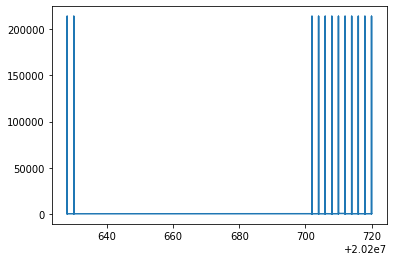

In [ ]:
# X_noscale = scalar.inverse_transform(X_test)
print(max(predicted_noscale))
print(max(covid_county["cases"]))
plt.plot(X_noscale[:, 0], predicted)
print()
data = pd.DataFrame(data=X_test, columns=["date", "state", "FIPS"]).astype(int)
data2 = pd.DataFrame(data=predicted, columns=["predicted"])
data3 = pd.DataFrame(data=y_test, columns=["actual"])

data_all = pd.concat([data, data2, data3], axis=1)
data_all
data_all[data_all["FIPS"]==6059]

# Probability

In [ ]:
pop = demographics_raw[["FIPS code", "AGEGRP", "TOT_POP", "TOT_MALE", "TOT_FEMALE"]]
pop.rename(columns={"FIPS code": "fips"}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
prob_stuff = pop
prob_stuff["fips"] = prob_stuff["fips"].astype(np.float64)
prob_stuff = prob_stuff.merge(fips_county_state, on="fips", how="left")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
prob_stuff_state = prob_stuff.groupby(by=["state", "AGEGRP"]).sum().drop(columns=["fips"])
prob_stuff_state["%_MALE"] = prob_stuff_state["TOT_MALE"] / prob_stuff_state["TOT_POP"]
prob_stuff_state["%_FEMALE"] = prob_stuff_state["TOT_FEMALE"] / prob_stuff_state["TOT_POP"]
prob_stuff_state.reset_index(inplace=True)
prob_stuff_state.rename(columns={"state":"State"}, inplace=True)


In [ ]:
new_age_mapping = {
  0: "All ages",
  1: "Under 4 years",
  2: "5-14 years",
  3: "5-14 years",
  4: "15-24 years",
  5: "15-24 years",
  6: "25-34 years",
  7: "25-34 years",
  8: "35-44 years",
  9: "35-44 years",
  10: "45-54 years",
  11: "45-54 years",
  12: "55-64 years",
  13: "55-64 years",
  14: "65-74 years",
  15: "65-74 years",
  16: "75-84 years",
  17: "75-84 years",
  18: "85 years and over"
  }

In [ ]:
prob_stuff_state["AGEGRP"].replace(new_age_mapping, inplace=True)
prob_stuff_state = prob_stuff_state.groupby(by=["State", "AGEGRP"]).sum().reset_index()

In [ ]:
percent_age_sex2 = percent_age_sex
percent_age_sex2["Age group"].replace({"Under 1 year":"Under 4 years", "1-4 years":"Under 4 years"}, inplace=True)
percent_age_sex2 = percent_age_sex2.groupby(by=["State", "Sex", "Age group"]).sum().reset_index()

In [ ]:
deaths_sex = percent_age_sex2.groupby(by=["State", "Sex", "Age group"]).sum()
deaths_sex.reset_index(inplace=True)
deaths_sex.rename(columns={"Age group":"AGEGRP"}, inplace=True)

deaths_female = deaths_sex[deaths_sex["Sex"] == "Female"]
deaths_male = deaths_sex[deaths_sex["Sex"] == "Male"]

prob_stuff_state2 = prob_stuff_state.merge(deaths_male.drop(columns=["percent death"]), how="left", on=["State", "AGEGRP"])
prob_stuff_state2.rename(columns={"COVID-19 Deaths": "covid_deaths_male"}, inplace=True)
prob_stuff_state2.drop(columns="Sex", inplace=True)
prob_stuff_state2 = prob_stuff_state2.merge(deaths_female.drop(columns=["percent death"]), how="left", on=["State", "AGEGRP"])
prob_stuff_state2.rename(columns={"COVID-19 Deaths": "covid_deaths_female"}, inplace=True)
prob_stuff_state2.drop(columns="Sex", inplace=True)


In [ ]:
state_deaths = total_age_sex_by_state.first().reset_index()

final_prob_data = prob_stuff_state2

final_prob_data = final_prob_data.merge(state_deaths, how="left", on="State").rename(columns={"COVID-19 Deaths": "covid_deaths_total"})
final_prob_data["%_covid_deaths_male"] = final_prob_data["covid_deaths_male"] / final_prob_data["covid_deaths_total"]
final_prob_data["%_covid_deaths_female"] = final_prob_data["covid_deaths_female"] / final_prob_data["covid_deaths_total"]

TOT_STATE_POP = final_prob_data[["State", "TOT_POP"]].groupby(by="State").sum().reset_index()
TOT_STATE_POP.rename(columns={"TOT_POP": "TOT_POP_STATE"}, inplace=True)
TOT_STATE_POP["TOT_POP_STATE"] = TOT_STATE_POP["TOT_POP_STATE"] / 2

final_prob_data = final_prob_data.merge(TOT_STATE_POP, how="left", on="State")
final_prob_data["%_MALE"] = final_prob_data["TOT_MALE"] / final_prob_data["TOT_POP_STATE"]
final_prob_data["%_FEMALE"] = final_prob_data["TOT_FEMALE"] / final_prob_data["TOT_POP_STATE"]

adjustments = final_prob_data[["State", "AGEGRP"]]
adjustments["male"] = final_prob_data["%_covid_deaths_male"] / final_prob_data["%_MALE"]
adjustments["female"] = final_prob_data["%_covid_deaths_female"] / final_prob_data["%_FEMALE"]

adjustments[adjustments["State"] == "Alabama"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,State,AGEGRP,male,female
0,Alabama,15-24 years,0.000000,0.000000
1,Alabama,25-34 years,0.000000,0.000000
2,Alabama,35-44 years,0.000000,0.202189
3,Alabama,45-54 years,0.687730,0.402345
4,Alabama,5-14 years,0.000000,0.000000
5,Alabama,55-64 years,1.226456,0.921816
6,Alabama,65-74 years,2.908712,2.088859
7,Alabama,75-84 years,6.383458,4.045445
8,Alabama,85 years and over,15.963495,11.521070
9,Alabama,All ages,1.064900,0.939305


# Statistics

In [ ]:
covid_county

,county,state,fips,cases,deaths
date,,,,,
2020-01-21,Snohomish,Washington,53061.0,1,0
2020-01-22,Snohomish,Washington,53061.0,1,0
2020-01-23,Snohomish,Washington,53061.0,1,0
2020-01-24,Cook,Illinois,17031.0,1,0
2020-01-24,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...
2020-08-04,Meade,Kentucky,21163.0,99,2
2020-08-04,Menifee,Kentucky,21165.0,29,0
2020-08-04,Mercer,Kentucky,21167.0,77,0


In [ ]:
fips_dict = {}
for fips in covid_county["fips"].value_counts().index:
  data = covid_county[covid_county["fips"] == fips][["cases"]].astype(np.float64)
  data = data.asfreq('D')
  #data['cases'] = data['cases'].diff()
  #data[data['cases'] < 0] = 0
  train = data[:int (data.shape[0]*0.8)]
  test = data[int (data.shape[0]*0.8):]
  fips_dict[fips] = (train,test, data)

In [ ]:
updated_fips_dict = {}
for key in fips_dict:
  if(len(fips_dict[key][2]) > 50):
    updated_fips_dict[key] = fips_dict[key]

print(len(updated_fips_dict))

3087


In [ ]:
from bokeh.models import ColumnDataSource, Legend, LegendItem, Scatter
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models.tools import HoverTool

# contrived dataset
# fit model
  
TOOLS = "pan, wheel_zoom,reset, save" # the tools you want to add to your graph

def plot_county_2(fips, forecast,confidence):
  previous_cases = updated_fips_dict[fips][2]
  test_cases = updated_fips_dict[fips][1]
  yesterday = test_cases.index[len(test_cases.index)-1]
  start_date = yesterday + pd.Timedelta(days=1)
  date_indices = pd.date_range(start=start_date, periods = len(forecast))
  data_cases = ColumnDataSource(previous_cases)
  fc = {'cases':forecast, 'date':date_indices}
  forecast_cases = ColumnDataSource(pd.DataFrame(fc))
  county = fips_county_state[fips_county_state['fips']==fips].county.values[0]
  state = fips_county_state[fips_county_state['fips']==fips].state.values[0]
  title = "Cumulative Infections for "+county+" County in "+ state
  p = figure(title=title, x_axis_type='datetime', tools=TOOLS)
  p.line(x="date",y="cases",source=data_cases, line_color = '#6d70a3', line_width=3,legend_label="Previous Cases")
  p.line(x="date",y="cases",source=forecast_cases,line_width=3,line_color='#f0ce71',legend_label="Forcasted cases")
  p.legend.location = "top_left"
  p.background_fill_color = "#8d90b3"
  p.background_fill_alpha = 0.15
  p.xgrid.grid_line_color = "white"
  p.ygrid.grid_line_color = "white"
  p.xaxis.axis_label = 'Date'
  p.yaxis.axis_label = 'Cumulative number of Infections'
  hover = HoverTool(tooltips=[('date', '@date{%F}'),('cases', '@cases{0}')],
          formatters={'@date': 'datetime'})
  p.add_tools(hover)
  output_notebook() # show the output in jupyter notebook
  show(p)

In [ ]:
forecast, accuracy, conf, order = forecast_county(51153, 20)
print(accuracy)
plot_county_2(51153,forecast,conf)

{'mape': 0.023133474707966565, 'rmse': 207.6695224431287, 'corr': 0.997958774976052}


In [ ]:

# contrived dataset
# fit model
  
def plot_county(fips, forecast,confidence): 
  print(len(forecast))
  previous_cases = updated_fips_dict[fips][2]
  test_cases = updated_fips_dict[fips][1]
  yesterday = test_cases.index[len(test_cases.index)-1]
  start_date = yesterday + pd.Timedelta(days=1)
  date_indices = pd.date_range(start=start_date, periods = len(forecast))
  fc_series = pd.Series(forecast, index=date_indices)
  lower_series = pd.Series(confidence[:, 0], index=date_indices)
  upper_series = pd.Series(confidence[:, 1], index=date_indices)
  # Plot
  
  fig,ax = plt.subplots(figsize=(14,5), dpi=100)
  myFmt = DateFormatter("%m-%d-%Y")
  ax.xaxis.set_major_formatter(myFmt)

  ax.plot_date(previous_cases.index, previous_cases, linestyle='solid',label='previous cases')
  ax.plot(fc_series, label='forecast')
  ax.fill_between(date_indices, lower_series, upper_series, 
                  color='k', alpha=.15)
  plt.title('Forecast vs Actuals')
  plt.tight_layout()
  locator = mdate.DateLocator()
  fig.autofmt_xdate()
  plt.legend(loc='upper left', fontsize=8)
  ax.set(xlabel="Date",
        ylabel="Total Infections")
  plt.setp(ax.get_xticklabels(), rotation=45)
  plt.show()

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape,'rmse':rmse,'corr':corr})
    


In [ ]:
def forecast_county(fips, num_days): 
  county_data = updated_fips_dict[fips]
  num_days_test = min(num_days, len(county_data[1]))
  model = pm.auto_arima(county_data[2], start_p=1, start_q=1,
                      test='adf',                # use adftest to find optimal 'd'
                      max_p=3, max_q=3,          # maximum p and q
                      m=1,                        # frequency of series
                      d=None,                     # let model determine 'd'
                      seasonal=False,             # No Seasonality
                      start_P=0, 
                      D=0, 
                      out_of_sample_size=1,
                      # trace=True,
                      missing="drop",
                      error_action='ignore',  
                      suppress_warnings=True, 
                      information_criterion='oob',
                      scoring='mse',
                      stepwise=True)
  order = model.order
  try:
    model = ARIMA(county_data[2], order=order, missing="drop")
    model_fit = model.fit(disp=0)
    fc, se, conf = model_fit.forecast(num_days, alpha=.05)
    model_test = ARIMA(county_data[0], order=order, missing="drop")
    model_test_fit = model_test.fit(disp=0)
    fc_test, se_test, conf_test = model_test_fit.forecast(num_days_test, alpha=.05)
  except:
    model = SARIMAX(county_data[2], trend='c', order=(3, 2, 1), enforce_stationarity=False, enforce_invertibility=False, missing="drop")
    model_fit = model.fit(disp=0)
    fc = model_fit.forecast(num_days, alpha=0.5)
    conf = fc.conf_int()
    model_test = SARIMAX(county_data[0], trend='c', order=(3, 2, 1), enforce_stationarity=False, enforce_invertibility=False, missing="drop")
    model_test_fit = model.fit(disp=0)
    fc_test = model_test_fit.forecast(num_days_test, alpha=0.5)
  acc = forecast_accuracy(fc_test, county_data[1].values.squeeze(1)[:num_days_test])
  return fc, acc, conf, order

{'mape': 0.06758607924366097, 'rmse': 618.8122479328906, 'corr': 0.9986133979803408}
20


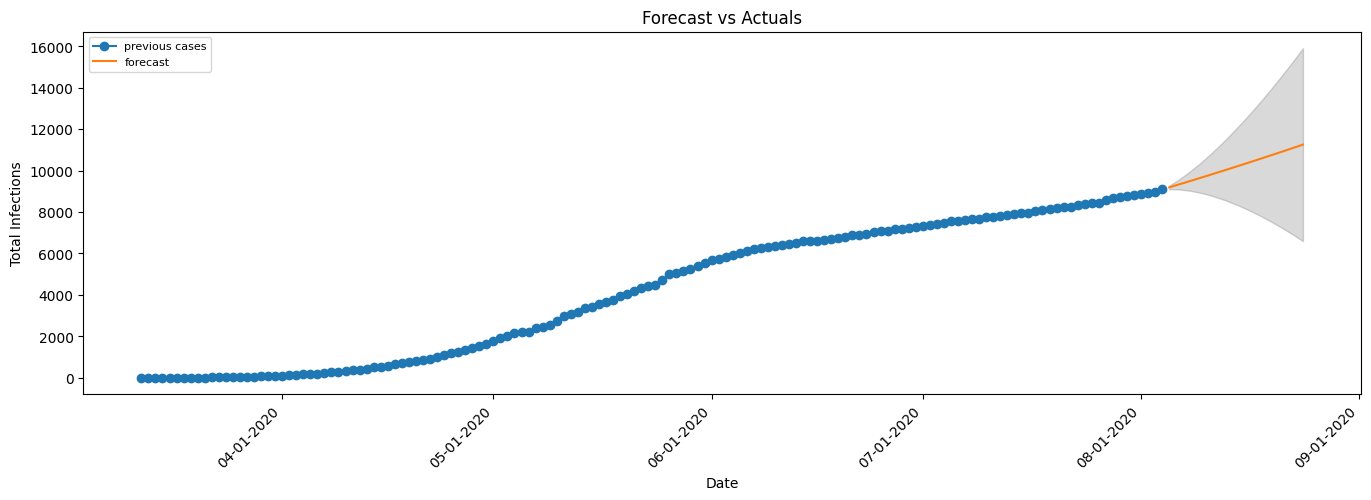

In [ ]:
forecast, accuracy, conf, order = forecast_county(51153, 20)
print(accuracy)
plot_county(51153,forecast,conf)

20


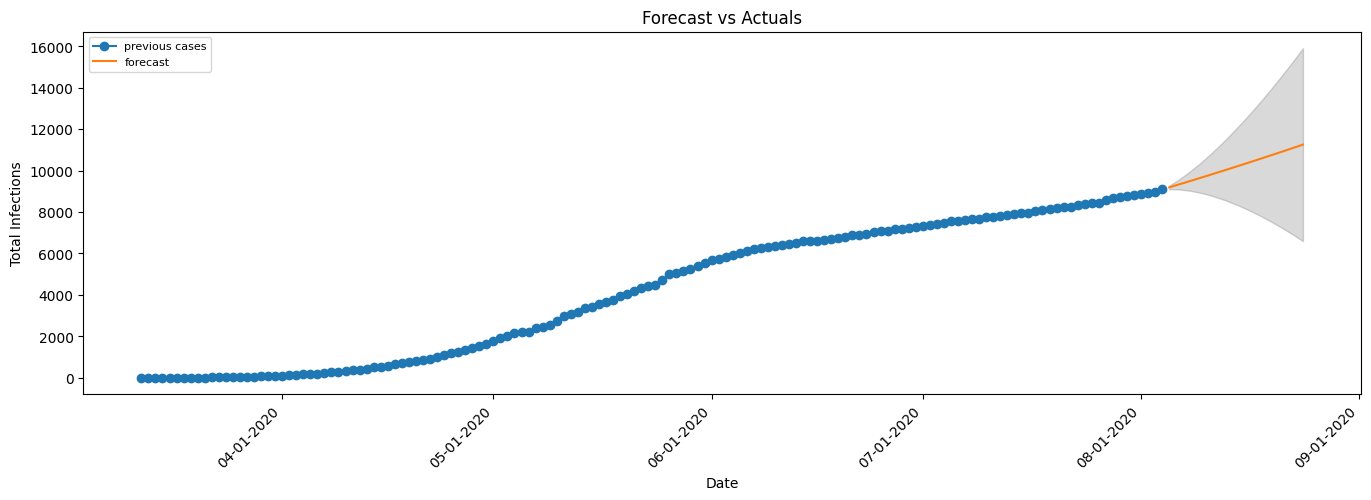

In [ ]:
plot_county(51153,forecast,conf)

In [ ]:
fips_dict[16061][2]

,cases
date,
2020-07-06,1.0
2020-07-07,1.0
2020-07-08,1.0


## Get Accuracy of forecast model

In [ ]:
mapes = []
rmses = []
coors = []
orders = {}
problem_counties = []
num_counties = 0
for key in updated_fips_dict:
  if(key != 0):  
    if num_counties % 100 == 0:
      print("Have forecasted {} counties", num_counties)
    num_counties += 1
    try:
      forecast, confidence, accuracy, order = forecast_county(key, 20)
      orders[key] = order
      coors.append(accuracy['corr'])
      mapes.append(accuracy['mape'])
      rmses.append(accuracy['rmse'])
    except:
      problem_counties.append(key)
      orders[key] = None
      print(key)

Have forecasted {} counties 0


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Have forecasted {} counties 100


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: Converge

Have forecasted {} counties 200


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodel

Have forecasted {} counties 300


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting 

Have forecasted {} counties 400


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Have forecasted {} counties 500


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/st

Have forecasted {} counties 600


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: 

Have forecasted {} counties 700


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.6/dist-pac

Have forecasted {} counties 800


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np

Have forecasted {} counties 900


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: 

Have forecasted {} counties 1000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsato

Have forecasted {} counties 1100


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inv

Have forecasted {} counties 1200


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: Ru

Have forecasted {} counties 1300


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.ex

Have forecasted {} counties 1400


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value enc

Have forecasted {} counties 1500


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py

Have forecasted {} counties 1600


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in exp
  newparam

Have forecasted {} counties 1700


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarn

Have forecasted {} counties 1800


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/mode

Have forecasted {} counties 1900


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.6

Have forecasted {} counties 2000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1866: RuntimeWarning: invalid value encountered in sqrt
  fcerr = np.sqrt(np.cumsum(cumsum_n(ma_rep, self.k_diff) ** 2) * sigma2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packa

Have forecasted {} counties 2100


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or

Have forecasted {} counties 2200


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: Runtim

Have forecasted {} counties 2300


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local

Have forecasted {} counties 2400


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered 

Have forecasted {} counties 2500


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools

Have forecasted {} counties 2600


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c

Have forecasted {} counties 2700


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:1699: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + 2 * (1 + self.df_model) / self.nobs
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:1741: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + (1 + self.df_model) * np.log(nobs) / nobs
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:1713: RuntimeWarning: divide by zero encount

Have forecasted {} counties 2800


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


20023.0


/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
 

Have forecasted {} counties 2900


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3

Have forecasted {} counties 3000


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:397: UserWarning: Input ti

In [ ]:
cleaned_coors = [x for x in coors if str(x) != 'nan']
cleaned_mapes = [x for x in mapes if str(x) != 'nan']
cleaned_rmses = [x for x in rmses if str(x) != 'nan']
avg_mape = sum(cleaned_mapes)/len(cleaned_mapes)
avg_rmse = sum(cleaned_rmses)/len(cleaned_rmses)
avg_coor = sum(cleaned_coors)/len(cleaned_coors)
print("Average mape: "+str(avg_mape))
print("Average rmse: "+str(avg_rmse))
print("Average coorelation: "+str(avg_coor))
print(len(mapes))
print(len(problem_counties))
print(len(fips_dict))

Average mape: 0.13072481795455165
Average rmse: 70.68069440115633
Average coorelation: 0.8959890300255774
3081
1
3192


In [ ]:
num_counties = 0
problem_counties_2 = []
for key in problem_counties:
  if(key != 0):  
    if num_counties % 30 == 0:
      print("Have forecasted {} counties", num_counties)
    num_counties += 1
    try:
      forecast, confidence, accuracy, order = forecast_county(key, 20)
      coors.append(accuracy['corr'])
      mapes.append(accuracy['mape'])
      rmses.append(accuracy['rmse'])
    except:
      problem_counties_2.append(key)
      print(key)

Have forecasted {} counties 0
20023.0


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Have forecasted {} counties 30
Have forecasted {} counties 60


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Have forecasted {} counties 90


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp

Have forecasted {} counties 120


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-p

Have forecasted {} counties 150


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/mlemodel.py:4161: RuntimeWarning: invalid value encountered in sqrt
  se_mean = np.sqrt(self.var_pred_mean)
/usr/local/lib/python3.6/d

Have forecasted {} counties 180


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
 

Have forecasted {} counties 210


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, 

Have forecasted {} counties 240


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: 

Have forecasted {} counties 270


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/states

Have forecasted {} counties 300


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1886: Runti

46055.0


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:849: RuntimeWarning: divide by zero encountered in log
  llf = -nobs / 2. * (log(2 * pi) + log(sigma2)) - ssr / (2 * sigma2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:849: RuntimeWarning: invalid value encountered in double_scalars
  llf = -nobs / 2. * (log(2 * pi) + log(sigma2)) - ssr / (2 * sigma2)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: inval

38047.0


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Have forecasted {} counties 330
53023.0


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: 

40129.0


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals"

31057.0


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:849: RuntimeWarning: divide by zero encountered in log
  llf = -nobs / 2. * (log(2 * pi) + log(sigma2)) - ssr / (2 * sigma2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:849: RuntimeWarning: invalid

16033.0
Have forecasted {} counties 360
30077.0
6049.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:849: RuntimeWarning: divide by zero encountered in log
  llf = -nobs / 2. * (log(2 * pi) + log(sigma2)) - ssr / (2 * sigma2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:849: RuntimeWarning: invalid value encountered in double_scalars
  llf = -nobs / 2. * (log(2 * pi) + log(sigma2)) - ssr / (2 * sigma2)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.6/dist-pack

In [ ]:
cleaned_coors = [x for x in coors if str(x) != 'nan']
cleaned_mapes = [x for x in mapes if str(x) != 'nan']
cleaned_rmses = [x for x in rmses if str(x) != 'nan']
avg_mape = sum(cleaned_mapes)/len(cleaned_mapes)
avg_rmse = sum(cleaned_rmses)/len(cleaned_rmses)
avg_coor = sum(cleaned_coors)/len(cleaned_coors)
print("Average mape: "+str(avg_mape))
print("Average rmse: "+str(avg_rmse))
print("Average coorelation: "+str(avg_coor))
print(len(mapes))
print(len(cleaned_mapes))
print(len(cleaned_coors))
print(len(fips_dict))

# Average mape: 0.13100997746657328
# Average rmse: 68.45831131451877
# Average coorelation: 0.8886305390902969

Average mape: 0.13100997746657328
Average rmse: 68.45831131451877
Average coorelation: 0.8886305390902969
3183
3182
3003
3192
6


In [ ]:
forecast, confidence, accuracy, order = forecast_county(20023, 20)
print(accuracy)
print(order)

ValueError: ignored